In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os 
import pathlib 
from keras.utils.layer_utils import get_source_inputs
from tensorflow.keras.layers import Layer, InputSpec
from keras_vggface.vggface import VGGFace
from keras.models import Model
from keras.layers import Dense
from tqdm import tqdm
import keras
from keras.utils import np_utils

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from tensorflow.keras import mixed_precision

# Set the policy to mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce GTX 1650 SUPER, compute capability 7.5


In [4]:
import requests
url = "https://raw.githubusercontent.com/Meta-c/Helper-ML/master/ML_functions.py"

response = requests.get(url)
code = response.text

exec(code)

In [5]:
train_img=np.load('images_128.npy')
train_labels=np.load('labels_128.npy')
val_img=np.load('val_images_128.npy')
val_labels=np.load('val_labels_128.npy')

Text(0.5, 1.0, 'Heart')

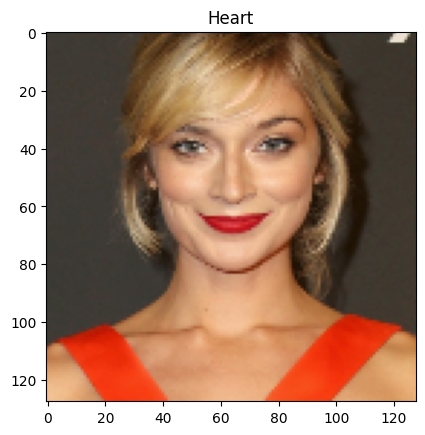

In [6]:
plt.imshow(cv2.cvtColor(train_img[262], cv2.COLOR_BGR2RGB))
plt.title(train_labels[262])

In [7]:
# Define the face shapes and their labels
face_shapes = {
    "Oval": 0,
    "Round": 1,
    "Square": 2,
    "Heart": 3,
    "Oblong": 4
}

In [8]:
test=face_shapes['Round']
test

1

In [9]:
for i in range(train_labels.__len__()):
    train_labels[i]=face_shapes[train_labels[i]]
    

In [10]:
for i in range(val_labels.__len__()):
    val_labels[i]=face_shapes[val_labels[i]]

In [11]:
train_labels=train_labels.astype('int16')

In [12]:
val_labels=val_labels.astype('int16')

In [13]:
# Convert to array

train_img_16=np.asarray(train_img).astype('float16').reshape(-1,128,128,3)


In [14]:
train_img_16.shape,train_labels.shape

((3736, 128, 128, 3), (3736,))

In [15]:
# Convert to array

val_img_16=np.asarray(val_img).astype('float16').reshape(-1,128,128,3)


In [16]:
val_img_16.shape,val_labels.shape

((923, 128, 128, 3), (923,))

In [17]:
labels=set(val_labels)
print(labels)

{0, 1, 2, 3, 4}


In [31]:
import tensorflow as tf
from keras_vggface.vggface import VGGFace
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# Load the VGGFace model (excluding the top classification layer)
vgg_model = VGGFace(model='vgg16', include_top=False, input_shape=(128, 128, 3))

# Freeze the weights of the base model
for layer in vgg_model.layers:
    layer.trainable = False

# Add new layers for face shape classification
x = vgg_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(5, activation='softmax')(x)  # Output layer with 5 classes

# Create the customized model
custom_model = Model(inputs=vgg_model.input, outputs=output)


In [33]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

# Compile the model
custom_model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [28]:
y_train = np_utils.to_categorical(train_labels, 5)
y_val = np_utils.to_categorical(val_labels, 5)

In [29]:
# Set up data generators for training and validation
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.1, height_shift_range=0.1)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_img_16,y_train, batch_size=16)


valid_generator = valid_datagen.flow(val_img_16,y_val,  batch_size=16)



In [34]:
custom_model.output_shape

(None, 5)

In [23]:
train_generator.y.shape

(3736, 5)

In [35]:
# Train the model
history=custom_model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=valid_generator, validation_steps=len(valid_generator))

Epoch 1/10
234/234 [==============================] - 24s 97ms/step - loss: 1.5938 - accuracy: 0.2810 - val_loss: 1.5747 - val_accuracy: 0.3304
Epoch 2/10
234/234 [==============================] - 24s 101ms/step - loss: 1.5639 - accuracy: 0.3453 - val_loss: 1.5497 - val_accuracy: 0.3489
Epoch 3/10
234/234 [==============================] - 22s 95ms/step - loss: 1.5406 - accuracy: 0.3611 - val_loss: 1.5305 - val_accuracy: 0.3597
Epoch 4/10
234/234 [==============================] - 21s 89ms/step - loss: 1.5223 - accuracy: 0.3812 - val_loss: 1.5145 - val_accuracy: 0.3965
Epoch 5/10
234/234 [==============================] - 21s 89ms/step - loss: 1.5064 - accuracy: 0.3911 - val_loss: 1.5005 - val_accuracy: 0.3976
Epoch 6/10
234/234 [==============================] - 21s 89ms/step - loss: 1.4928 - accuracy: 0.3994 - val_loss: 1.4879 - val_accuracy: 0.4030
Epoch 7/10
234/234 [==============================] - 21s 90ms/step - loss: 1.4833 - accuracy: 0.4018 - val_loss: 1.4796 - val_accuracy

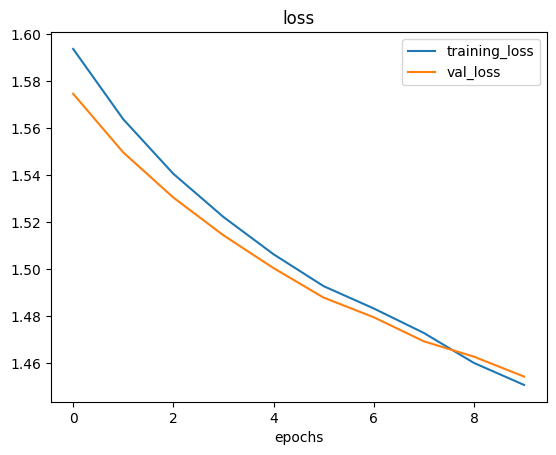

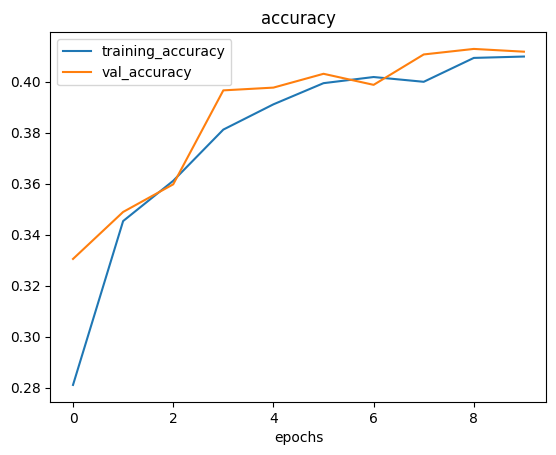

In [36]:
plot_loss_curves(history)

In [37]:
more_epochs_history=custom_model.fit(train_generator, steps_per_epoch=len(train_generator), epochs=10, validation_data=valid_generator, validation_steps=len(valid_generator))

Epoch 1/10
234/234 [==============================] - 21s 90ms/step - loss: 1.4458 - accuracy: 0.4168 - val_loss: 1.4452 - val_accuracy: 0.4139
Epoch 2/10
234/234 [==============================] - 21s 89ms/step - loss: 1.4371 - accuracy: 0.4200 - val_loss: 1.4394 - val_accuracy: 0.4171
Epoch 3/10
234/234 [==============================] - 21s 91ms/step - loss: 1.4290 - accuracy: 0.4232 - val_loss: 1.4349 - val_accuracy: 0.4225
Epoch 4/10
234/234 [==============================] - 21s 91ms/step - loss: 1.4212 - accuracy: 0.4336 - val_loss: 1.4281 - val_accuracy: 0.4215
Epoch 5/10
234/234 [==============================] - 21s 89ms/step - loss: 1.4179 - accuracy: 0.4312 - val_loss: 1.4234 - val_accuracy: 0.4280
Epoch 6/10
234/234 [==============================] - 21s 90ms/step - loss: 1.4136 - accuracy: 0.4331 - val_loss: 1.4205 - val_accuracy: 0.4312
Epoch 7/10
234/234 [==============================] - 22s 92ms/step - loss: 1.4049 - accuracy: 0.4395 - val_loss: 1.4152 - val_accuracy:

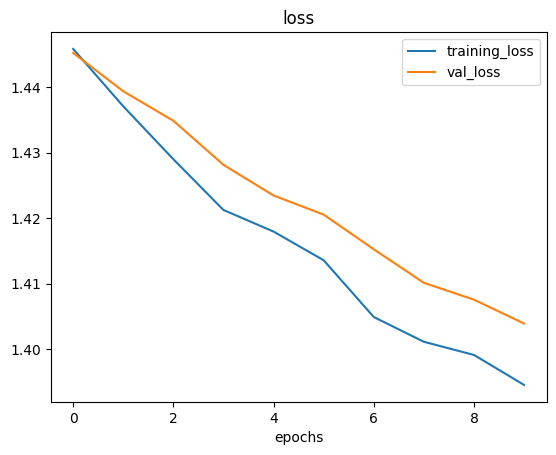

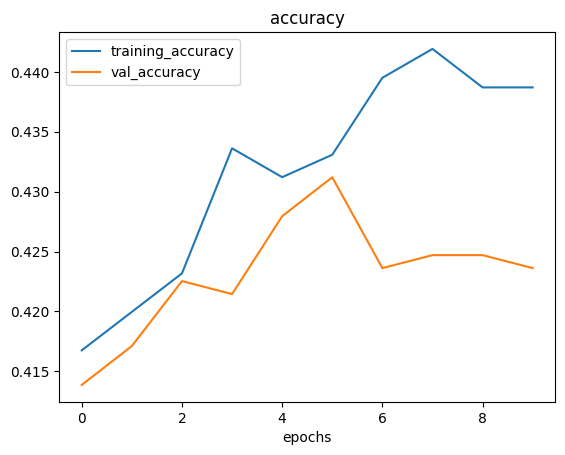

In [38]:
plot_loss_curves(more_epochs_history)